#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18B Forecasting a home price index**

using case-schiller-la dataset

version 1.0 2021-05-05

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from datetime import datetime
import sys
import statsmodels
import patsy
import pmdarima
import statsmodels.formula.api as smf
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir), "da_data_repo/case-shiller-la/clean/")
data_out = os.path.join(str(base_dir), "da_data_repo/ch18-case-shiller-la/")
output = os.path.join(data_out, "output")
func = os.path.join(str(base_dir), "da_case_studies/ch00-tech-prep/")

In [5]:
sys.path.append(func)
from py_helper_functions import *

In [6]:
csv_path = os.path.join(data_in,"homeprices-data-2000-2018.csv")
data = pd.read_csv(csv_path)

In [7]:
data.head()

date  year  month          ps         pn   us   un     emps     empn
0  2000-01-01  2000      1  101.031209  100.00000  5.0  5.4  14344.4  14132.8
1  2000-02-01  2000      2  102.043406  100.61896  5.0  5.3  14390.4  14270.0
2  2000-03-01  2000      3  103.224699  102.12780  5.0  5.3  14429.1  14421.3
3  2000-04-01  2000      4  104.159399  103.70410  5.0  4.7  14484.6  14450.8
4  2000-05-01  2000      5  104.924698  104.98908  5.0  4.7  14549.9  14590.2

In [8]:
data = data.assign(date=lambda x: x.date.str[0:7])

data = data.rename({"pn": "p", "us": "u", "emps": "emp"}, axis=1)

In [9]:
data = data.sort_values(by=["date"]).assign(
    dp=lambda x: x.p.diff(1),
    p_lag=lambda x: x.p.shift(1),
    lnp=lambda x: np.log(x.p),
    dlnp=lambda x: x.lnp.diff(1),
    lnp_lag=lambda x: x.lnp.shift(1),
    dlnp_lag=lambda x: x.dlnp.shift(1),
    du=lambda x: x.u.diff(1),
    lnemp=lambda x: np.log(x.emp),
    dlnemp=lambda x: x.lnemp.diff(1),
    trend=lambda x: range(1, data.shape[0] + 1),
)

In [10]:
# now save the workfile with data from 2000 through 2018

data.to_pickle("case-shiller-workfile-2000-2018.pkl")

In [11]:
# and now create and save the workfile with data from 2000 through 2017

data = data.loc[lambda x: x.year <= 2017]
data.to_pickle("case-shiller-workfile-2000-2017.pkl")

In [12]:
# Figure 18.8

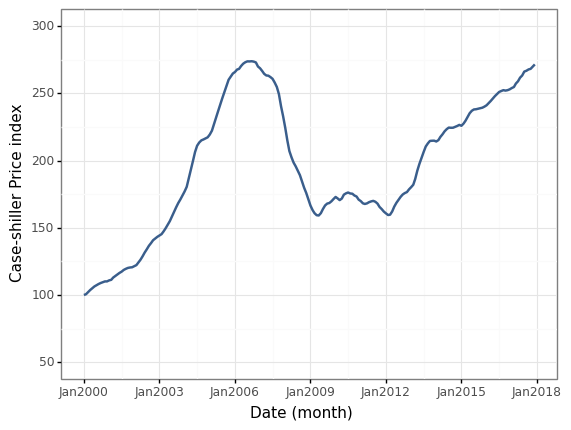

<ggplot: (322410798)>

In [13]:
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("1 year")

price_index_plot = (
    ggplot(data, aes(x="date", y="p", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[50, 300], breaks=seq(50, 301, 50))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Case-shiller Price index", x="Date (month)")
    + theme_bw()
)
price_index_plot

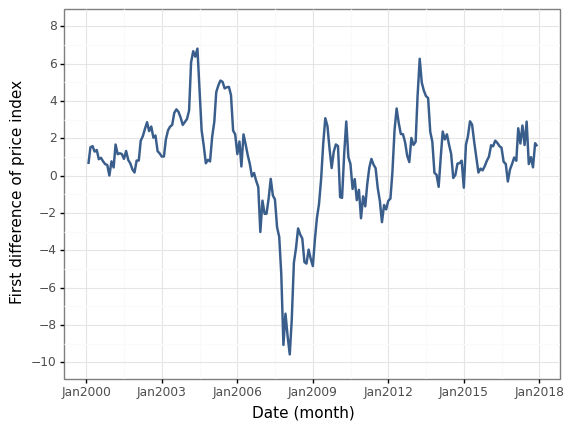

<ggplot: (324994006)>

In [88]:
# additional graphs, not in textbook
# Plot log difference of price index

dp_plot = (
    ggplot(data, aes(x="date", y="dp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-10, 8], breaks=seq(-10, 9, 2))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="First difference of price index", x="Date (month)")
    + theme_bw()
)
dp_plot

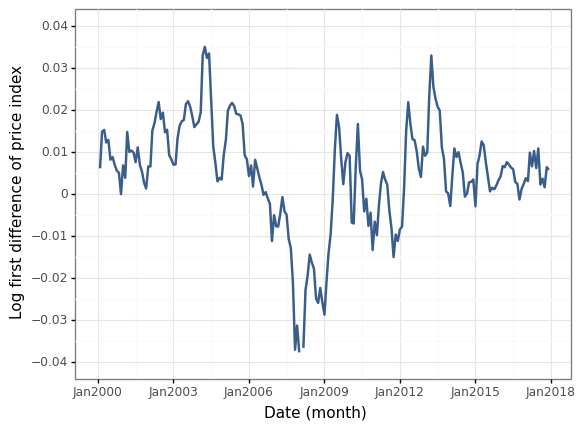

<ggplot: (324921125)>

In [89]:
# Plot log difference of price index
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)
breaks = date_breaks("1 year")

dlnp_plot = (
    ggplot(data, aes(x="date", y="dlnp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[-0.04, 0.04], breaks=seq(-0.04, 0.05, 0.01))
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log first difference of price index", x="Date (month)")
    + theme_bw()
)
dlnp_plot

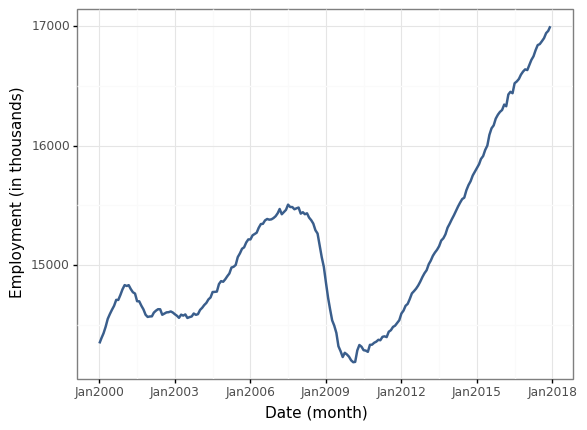

<ggplot: (324870599)>

In [90]:
## Figure 18.10

# additional graphs, not in textbook
# Plot log difference of price index

emp_plot = (
    ggplot(data, aes(x="date", y="emp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Employment (in thousands)", x="Date (month)")
    + theme_bw()
)
emp_plot

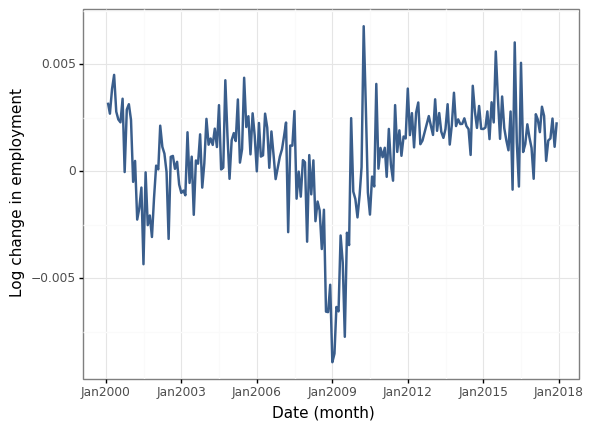

<ggplot: (325018149)>

In [91]:
# Plot log diff employment
lnemp_plot = (
    ggplot(data, aes(x="date", y="dlnemp", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Log change in employment", x="Date (month)")
    + theme_bw()
)

lnemp_plot

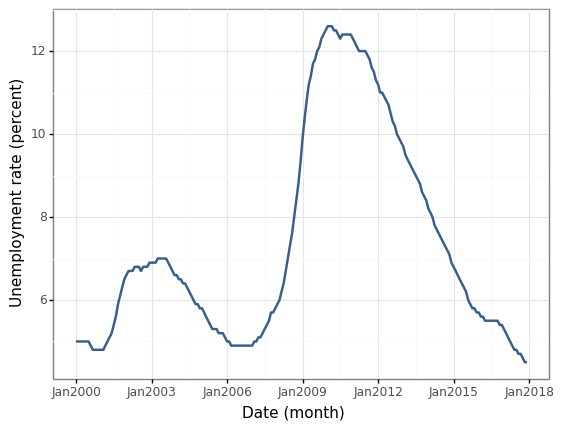

<ggplot: (325046221)>

In [92]:
# Plot unemployment rate
u_plot = (
    ggplot(data, aes(x="date", y="u", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Unemployment rate (percent)", x="Date (month)")
    + theme_bw()
)

u_plot

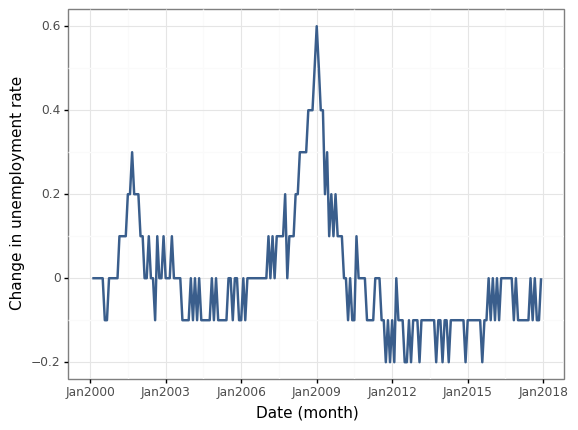

<ggplot: (325015257)>

In [93]:
# Plot diff unemployment

du_plot = (
    ggplot(data, aes(x="date", y="du", group=1))
    + geom_line(color=color[0], size=1)
    + scale_x_date(breaks=breaks(limits)[::3], labels=date_format("%b%Y"))
    + labs(y="Change in unemployment rate", x="Date (month)")
    + theme_bw()
)

du_plot

### Create work set and holdout set

In [14]:
from datetime import datetime
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m"))

In [15]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2017, :]
data_work = data.loc[lambda x: x["year"] < 2017, :]

In [16]:
# create training and test sets for 4 folds

for year in range(2013, 2017):
    fold = year - 2012
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (
        data_work["year"] >= year - 13
    )

In [46]:
from statsmodels.tsa.arima.model import ARIMA

rmse_fold = []
rmse_cv = []

In [47]:
# Model M1
# p on trend & seasonality
mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model = smf.ols("p ~ trend + C(month)", train_data).fit()

    phat = model.predict(test_data)

    errsq = np.square(test_data.p.values - phat)

    mse.append(np.mean(errsq))

rmse_cv_m1 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m1)

In [48]:
# Model M2
# p ARIMA(1,1,2)

mse = []

for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]
    
    model = ARIMA(train_data.p, order=(1, 1, 2)).fit()

    phat = model.forecast(steps=12)

    errsq = np.square(test_data.p.values - phat)

    mse.append(np.mean(errsq))

rmse_cv_m2 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m2)

In [49]:
# Model M3
# p ARIMA(1,1,0)

mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model = ARIMA(
        train_data.p, exog=pd.get_dummies(train_data.month), order=(1, 1, 0)
    ).fit()

    phat = model.forecast(steps=12, exog=pd.get_dummies(test_data.month))

    errsq = np.square(test_data.p.values - phat)

    mse.append(np.mean(errsq))

rmse_cv_m3 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m3)

# Model M4
# p ARIMA(2,0,0)

mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model = ARIMA(
        train_data.p,
        exog=pd.get_dummies(train_data.month).assign(t=train_data.trend),
        order=(2, 0, 0),
    ).fit()

    phat = model.forecast(
        steps=12, exog=pd.get_dummies(test_data.month).assign(t=test_data.trend)
    )

    errsq = np.square(test_data.p.values - phat)

    mse.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m4)

In [50]:
# Model M4
# p ARIMA(2,0,0) + seasonality + trend

mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model = ARIMA(
        train_data.p, exog=pd.get_dummies(train_data.month), trend="t", order=(2, 0, 0)
    ).fit()

    phat = model.forecast(steps=12, exog=pd.get_dummies(test_data.month), trend="t")

    errsq = np.square(test_data.p.values - phat)

    mse.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m4)

In [51]:
# Model M5
# dp ~ month + trend, without any ARIMA
mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model = smf.ols("dp ~ trend + C(month)", train_data).fit()

    dphat = model.predict(test_data)

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat.iloc[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat.iloc[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse.append(np.mean(errsq))

rmse_cv_m5 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m5)

In [52]:
# Model M6
# lnp ARIMA(0,2,0) + seasonality

mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model = ARIMA(
        train_data.lnp, exog=pd.get_dummies(train_data.month), order=(0, 2, 0)
    ).fit()

    lnphat = model.forecast(steps=12, exog=pd.get_dummies(test_data.month))
    
    corrb = mean_squared_error(test_data.lnp , lnphat)

    phat = np.exp((lnphat + corrb / 2))

    errsq = np.square(test_data.p.values - phat)

    mse.append(np.mean(errsq))

rmse_cv_m6 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m6)


In [25]:
from statsmodels.tsa.api import VAR

In [26]:
# VAR

mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model = VAR(train_data[["dp", "du", "dlnemp"]]).fit(1)

    dphat = model.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model.k_ar :], steps=12
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse.append(np.mean(errsq))

rmse_cv_m7 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m7)

In [53]:
# Note. This VAR includes month dummies
# Textbook results are from R, where 
# we could not figure out how to inlcude month dummies

mse = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model = VAR(
        train_data[["dp", "du", "dlnemp"]], exog=pd.get_dummies(train_data["month"])
    ).fit(1)

    dphat = model.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model.k_ar :],
        exog_future=pd.get_dummies(test_data["month"]).values,
        steps=12,
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse.append(np.mean(errsq))

rmse_cv_m7 = np.sqrt(np.mean(mse))
rmse_fold.append(np.sqrt(mse))
rmse_cv.append(rmse_cv_m7)

In [60]:
pd.DataFrame(rmse_fold, columns=["Fold" + str(i) for i in range(1, 5)]).assign(
    Average=rmse_cv, model=["M" + str(i) for i in range(1, 8)]
).round(2).set_index("model")

Fold1  Fold2  Fold3  Fold4  Average
model                                     
M1     14.90  17.59  34.43  48.58    31.93
M2     14.82   8.39   6.23   5.53     9.48
M3      6.68   1.39   3.28   3.22     4.11
M4      3.00   1.24   1.37   2.05     2.04
M5     33.94   9.79  10.42   7.39    18.78
M6      2.52   4.92   9.31   9.73     7.28
M7      5.69   1.85   5.05   4.57     4.53